In [87]:
# from __future__ import print_function
from __future__ import division

import json
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import gzip
from scipy.misc import imsave
import time
import scipy.ndimage

from keras import backend as K
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Dropout

from keras.layers import *
from keras.layers.merge import concatenate
from keras.models import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, Callback
from keras import losses

from keras.preprocessing.image import ImageDataGenerator

from scipy.ndimage import morphology
from numpy import linalg

import random
from itertools import islice

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "4"


In [3]:
cd ..

/home/malub_local/activelearningADS


## Utils

In [4]:
def preprocessor(input_img, img_rows, img_cols):
    """
    Resize input images to constants sizes
    :param input_img: numpy array of images
    :return: numpy array of preprocessed images
    """
    output_img = np.ndarray((input_img.shape[0], input_img.shape[1], img_rows, img_cols), dtype=np.uint8)
    
    for i in range(input_img.shape[0]):
        output_img[i, 0] = cv2.resize(input_img[i, 0], (img_cols, img_rows), interpolation=cv2.INTER_CUBIC)
    
    return output_img


def load_data(path_img, path_mask, img_rows, img_cols):
    """
    Load data from project path
    :return: [X, y] numpy arrays containing the [training, validation, test] data and their respective masks.
    """
    print("\nLoading data...\n")
    X = np.load(path_img)
    y = np.load(path_mask)

    X = preprocessor(X, img_rows, img_cols)
    y = preprocessor(y, img_rows, img_cols)

    X = X.astype('float32')

    mean = np.mean(X)  # mean for data centering
    std = np.std(X)  # std for data normalization

    X -= mean
    X /= std

    y = y.astype('float32')
    y /= 255.  # scale masks to [0, 1]
    return X, y



#### loss and metrics #####
def dice_coef(y_true, y_pred, smooth = 1.):
    """Compute Dice Coefficient between prediction and Ground Truth
    :param y_true: ground truth
    :param y_pred: prediction
    :param smooth: avoid division by 0
    :return: dice coefficient
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)




def weighted_binary_crossentropy(y_true, y_pred):
    """Compute the weighted binary cross-entropy
    :param y_true: ground truth
    :param y_pred: prediction
    :return: weighted binary cross-entropy
    """
    b_ce = K.binary_crossentropy(y_true, y_pred)  # Calculate the binary crossentropy
    weight_vector = y_true * 0.30 + (1. - y_true) * 0.70  # Apply the weights
    weighted_b_ce = weight_vector * b_ce        
    return K.mean(weighted_b_ce) # Return the mean error


### data augmentation ######
def data_generator():
    """
    :return: Keras data generator. Data augmentation parameters.
    """
    return ImageDataGenerator(
        fill_mode = fill_mode,
        rotation_range = rotation_range,
        horizontal_flip = horizontal_flip,
        vertical_flip = vertical_flip,
        rescale = rescale,
        zoom_range = zoom_range,
        channel_shift_range = channel_shift_range,
        width_shift_range = width_shift_range,
        height_shift_range = height_shift_range)
        #preprocessing_function = random_gaussian_noise)

def random_gaussian_noise(image):
    """Randomly apply gaussian noise to input image for data augmentation
    :param image: input image
    :return: noisy image
    """
    apply_gaussian_noise = random.choice([True, False])
    if apply_gaussian_noise == True:
        output_image = noisy(image)
    else:
        output_image = image
    return output_image
    

def noisy(image):
    """Apply gaussian noise to input image for data augmentation
    :param image: input image
    :return: noisy image
    """
    ch, row, col = image.shape
    mean = 0
    sigma = np.random.uniform(low=0.0, high=sigma_max, size=None)
    gauss = np.random.normal(mean, sigma, (ch, row,col))
    gauss = gauss.reshape(ch, row,col)
    noisy = image + gauss
    return noisy


def call(self, inputs, training=None):
    """Override Dropout. Make it able at test time
    """
    if 0. < self.rate < 1.:
        noise_shape = self._get_noise_shape(inputs)
        def dropped_inputs():
            return K.dropout(inputs, self.rate, noise_shape,
                             seed=self.seed)
        if (training):
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        else:
            return K.in_test_phase(dropped_inputs, inputs, training=None)
    return inputs


def reset_weights(model):
    """Initialize weights of Neural Networks
    """
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

            
            
def predict(data, model):
    """
    Data prediction for a given model
    :param data: input data to predict.
    :param model: unet model.
    :return: predictions.
    """
    return model.predict(data, verbose=0)

def compute_dice_coef(y_true, y_pred):
    """
    Computes the Dice-Coefficient of a prediction given its ground truth.
    :param y_true: Ground truth.
    :param y_pred: Prediction.
    :return: Dice-Coefficient value.
    """
    smooth = 1.  # smoothing value to deal zero denominators.
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def compute_uncertain(sample, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param model: unet model with Dropout layers.
    :return: averaged-thresholded predictions after nb_steps_prediction samples
    :return: overall uncertainty (not map)
    :return: uncertainty_map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)
    # averaged-thresholded predictions after np_step_prediction predicted samples
    X_prediction = cv2.threshold(np.mean(X, axis=0), threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return np.sum(var * transform)

    else:
        return X_prediction, np.sum(np.var(X, axis=0)), np.var(X, axis=0)


def compute_uncertain_map(sample, prediction, model):
    """
    Computes uncertainty map for a given sample and its prediction for a given model, based on the
    number of step predictions defined in constants file.
    :param sample: input sample.
    :param prediction: input sample prediction.
    :param model: unet model with Dropout layers.
    :return: uncertainty map.
    """
    X = np.zeros([1, img_rows, img_cols])

    for t in range(nb_step_predictions):
        prediction = model.predict(sample, verbose=0).reshape([1, img_rows, img_cols])
        X = np.concatenate((X, prediction))

    X = np.delete(X, [0], 0)

    if (apply_edt):
        # apply distance transform normalization.
        var = np.var(X, axis=0)
        transform = range_transform(edt(prediction))
        return var * transform

    else:
        return np.var(X, axis=0)  

## Unet

In [5]:
def unet_full_bn(dropout):
    inputs = Input((1, img_rows, img_cols))
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(inputs)
    conv1 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv1)
    batch1 = BatchNormalization(axis=1)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(batch1)
    pool1 = Dropout(dropout_proba)(pool1)


    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(pool1)
    conv2 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv2)
    batch2 = BatchNormalization(axis=1)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(batch2)
    pool2 = Dropout(dropout_proba)(pool2)

   
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(pool2)
    conv3 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv3)
    batch3 = BatchNormalization(axis=1)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(batch3)
    pool3 = Dropout(dropout_proba)(pool3)

    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(pool3)
    conv4 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv4)
    batch4 = BatchNormalization(axis=1)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(batch4)
    
    if dropout:
        pool4 = Dropout(dropout_proba)(pool4)
   
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(pool4)
    conv5 = Conv2D(512, (3, 3), padding="same", activation="relu")(conv5)

    if dropout:
        conv5 = Dropout(dropout_proba)(conv5)    

    up6_interm = UpSampling2D(size=(2, 2))(conv5)
    
    up6 = concatenate([up6_interm, conv4], axis=1)

    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(up6)
    conv6 = Conv2D(256, (3, 3), padding="same", activation="relu")(conv6)
    batch6 = BatchNormalization(axis=1)(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=1)
    
    if dropout:
        up7 = Dropout(dropout_proba)(up7)  
        
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(up7)
    conv7 = Conv2D(128, (3, 3), padding="same", activation="relu")(conv7)
    batch7 = BatchNormalization(axis=1)(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(batch7), conv2], axis=1)
    up8 = Dropout(dropout_proba)(up8)

    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(up8)
    conv8 = Conv2D(64, (3, 3), padding="same", activation="relu")(conv8)
    batch8 = BatchNormalization(axis=1)(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(batch8), conv1], axis=1)
    up9 = Dropout(dropout_proba)(up9)

    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(up9)
    conv9 = Conv2D(32, (3, 3), padding="same", activation="relu")(conv9)
    batch9 = BatchNormalization(axis=1)(conv9)

    conv10 = Conv2D(1, (1, 1), activation="sigmoid")(batch9)

    model = Model(outputs=conv10, inputs=inputs)

    model.compile(optimizer=Adam(lr = learning_rate, decay=decay_rate), loss=weighted_binary_crossentropy, 
                  metrics = [dice_coef])

    return model

In [6]:
def save_parameters(timestamp, params):
    """Save current parameters to text file
    :param timestamp:timestamp of the current run session
    :param params: dictionary of current parameters
    """
    param_file = str(param_path + 'params_' + timestamp + '.txt')
    txt_file = open(param_file,'w')
    txt_file.write(str(params))
    txt_file.close()
    
def get_params():
    """Convert list of current parameters to dictionary 
    """
    param_dict = {
    'img_rows':img_rows,
    'img_cols' : img_cols,
    'batch_size' : batch_size,
    'fill_mode' : fill_mode,
    'rotation_range': rotation_range,
    'horizontal_flip': horizontal_flip,
    'vertical_flip' : vertical_flip,
    'rescale' : rescale,
    'zoom_range': zoom_range,
    'channel_shift_range' : channel_shift_range,
    'width_shift_range' : width_shift_range,
    'height_shift_range' : height_shift_range,
    'nb_initial_epochs' : nb_initial_epochs,
    'apply_augmentation' : apply_augmentation,
    'nb_step_predictions': nb_step_predictions,
    'steps_per_epoch' : steps_per_epoch,
    'learning_rate' : learning_rate,
    'decay_rate' : decay_rate,
    'apply_edt' : apply_edt
    }
    return param_dict

## Score measure

In [7]:
## Score measure

def jaccard_score(y_pred, y_true):
    """Compute Jaccard Score (= Intersection / Union) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Jaccard score value
    """
    intersection = (y_pred * y_true).sum()
    union = y_pred.sum() + y_true.sum() - intersection
    if union == 0:
        return 1.
    else:
        return float(intersection)/union
    
def pixel_wise_accuracy(y_true, y_pred):
    """Compute Pixel-wise accuracy (= number of well classified pixel / total number of pixel) 
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Pixel-wise accuracy value
    """
    y_true_f = y_true.reshape([1, img_rows * img_cols])
    y_pred_f = y_pred.reshape([1, img_rows * img_cols])
    return 1 - np.count_nonzero(y_pred_f - y_true_f) / y_true_f.shape[1]
    

def distances(y_pred, y_true):
    d1 = morphology.distance_transform_edt(1- y_true) * y_pred
    d2 = morphology.distance_transform_edt(1 - y_pred) * y_true
    return d1, d2


def numeric_score(y_pred, y_true):
    """Compute True Positive, True Negative, False Positive, False Negative classifications
    between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: True Positive, True Negative, False Positive, False Negative
    """
    y_pred = y_pred.astype(int)
    y_true = y_true.astype(int)
    FP = float(np.sum((y_pred == 1) & (y_true == 0)))
    FN = float(np.sum((y_pred == 0) & (y_true == 1)))
    TP = float(np.sum((y_pred == 1) & (y_true == 1)))
    TN = float(np.sum((y_pred == 0) & (y_true == 0)))
    return FP, FN, TP, TN

def precision_score(y_pred, y_true):
    """Compute precision (= TP / (TP+FP)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Precision score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FP) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FP) 
    

def sensitivity_score(y_pred, y_true):
    """Compute sensitivity (= TP / (TP+FN)) between a prediction and its ground truth
    :param y_pred: prediction
    :param y_true: ground truth
    :return: Sensitivity score value
    """
    FP, FN, TP, TN = numeric_score(y_pred, y_true)
    if (TP + FN) <= 0:
        return 0.
    else:
        return np.divide(TP, TP + FN) 



In [8]:
## Rank the most uncertain predictions
def ranking(uncertain):
    return np.flip(np.argsort(uncertain), 0)

def to_be_annotated(uncertain, n):
    """Return index of the most n uncertain predictions"""
    return np.flip(np.argsort(uncertain), 0)[:n]

def add_annotated_sample(original, added, added_index):
    """append the annotated samples to the training set"""
    return np.vstack((original, added[added_index] ))


def remove_annotated(original, added_index):
    """remove annotated samples from unlabelled dataset"""
    new_index = np.delete(np.arange(len(original)), added_index)
    return original[new_index]

def random_index_generator(X_set, labelled_size, test_size):
    """Generate random index splits in labelled/unlabelled/test sets for active learning simulation
    :param X_set: initial dataset
    :param labelled_size: size of wished labelled set
    :param test_size: size of wished test set
    :return: labelled set index, unlabelled set index, test set index
    """
    unlabelled_size = len(X_set) - labelled_size - test_size
    index_labelled = np.random.choice(np.arange(len(X_set)), labelled_size, replace=False)
    index_unlabelled = np.setdiff1d(np.arange(len(X_set)), index_labelled)
    index_test = np.random.choice(index_unlabelled, test_size, replace=False)
    index_unlabelled = np.setdiff1d(index_unlabelled, index_test)
    return index_labelled, index_unlabelled, index_test

def data_splitting(X_set, labelled_size, test_size):
    unlabelled_size = len(X_set) - labelled_size - test_size
    index_labelled = np.arange(0, labelled_size, 1)
    index_unlabelled = np.arange(labelled_size, labelled_size + unlabelled_size, 1)
    index_test = np.arange(labelled_size + unlabelled_size, len(X_set), 1)
    return index_labelled, index_unlabelled, index_test

def random_train_valid_index_generator(data, ratio):
    train_size = int(len(data) * ratio)
    index_train = np.random.choice(np.arange(len(data)), train_size, replace=False)
    index_valid = np.setdiff1d(np.arange(len(data)), index_train)
    return index_train, index_valid

## Active Learing loop

In [9]:
def save_history(history, timestamp, iteration, history_path):
    """ Save training history in text file
    :param history: training history (numpy array)
    :param timestamp: timestamp of current run session
    :param iteration: active learning iteration number
    :param history_path: path to history text file
    """
    history_file = str(history_path + timestamp + '_history_iter_' +  str(iteration) +'_' + '.txt')
    txt_file = open(history_file,'w')
    txt_file.write(str(history))
    txt_file.close()
    
def scores(model, X_test, y_test, score_global):
    """Compute predictions scores on test set for the current active learning iteration
    :param model: trained Unet model
    :param X_test: test set
    :param y_test: test ground truth
    :param score global: numpy array with previous scores
    :return: numpy array with scores
    """
    uncertain_map = []
    uncertain = np.zeros(len(X_test))
    dice = np.zeros(len(X_test))
    jaccard = np.zeros(len(X_test))
    accuracy = np.zeros(len(X_test))
    sensitivity = np.zeros(len(X_test))
    precision = np.zeros(len(X_test))
    
    print("Computing predictions ...\n")
    predictions = predict(X_test, model)

    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice[i] = compute_dice_coef(y_test[i][0], sample_prediction)
        jaccard[i] = jaccard_score(sample_prediction, y_test[i][0, :, :])
        accuracy[i] = pixel_wise_accuracy(sample_prediction, y_test[i][0, :, :])
        sensitivity[i] = sensitivity_score(sample_prediction, y_test[i][0, :, :])
        precision[i] = precision_score(sample_prediction, y_test[i][0, :, :])
        _ , uncertain[i], uncertain_map_i = compute_uncertain(sample, model)
        #uncertain_map_i = compute_uncertain_map(sample, sample_prediction, model)
        uncertain_map.append(uncertain_map_i)

    uncertain_map_array = np.asarray(uncertain_map)
    print(uncertain_map_array.shape)
    print("Done computing predictions")

    metrics_array = np.array([np.mean(dice), np.mean(jaccard), np.mean(accuracy), np.mean(precision),
                                np.mean(sensitivity)])
    score_global = np.vstack((score_global, metrics_array))
    
    return score_global


def balance_uncertainty(sample_pred, uncertainty):
    """Multiply uncertainty by a ratio to overcome unbalanced class issues
    :param sample_pred: prediction for a sample
    :param uncertainty: associated uncertainty measure
    :return: scaled uncertainty measure
    """
    ratio = (1.0 / ((np.count_nonzero(sample_pred)+1.0) / (512*512* 1.0)))
    return uncertainty*ratio


def uncertainty_for_ranking(model, X_set):
    """Compute uncertainty and uncertainty map for a set of images
    :param model: trained Unet model
    :param X_set: set of data
    :return: numpy array with uncertainty value and numpy array of uncertainty maps for each image of X_set,
    and final prediction for X_set, which is an AVERAGE OF THE nb_step_prediction FORWARD PASS PREDICTIONS
    """
    # uncertainty computation for unlabelled
    print("Computing predictions for unlabelled data ...\n")
    uncertain_map = []
    uncertainty = np.zeros(len(X_set))
    predictions = predict(X_set, model)
    X = []
    for i in range(len(X_set)):
        sample = X_set[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        X_i, uncertainty_i, uncertain_map_i= compute_uncertain(sample, model)
        uncertainty[i] = balance_uncertainty(X_i, uncertainty_i) # scale uncertainty
        uncertain_map.append(uncertain_map_i)
        X.append(X_i)
    uncertain_map_array = np.asarray(uncertain_map)
    
    return uncertainty, uncertain_map, X




In [84]:
data_path = '../data/'
param_path = '../params/'

# PATH definition
checkpoint_weights_path = "./models/checkpoint_weights.hdf5"
final_weights_path = "./models/output_weights_batch_norm.hdf5"
intermediate_weights_path = "./models/intermediate_weights_batch_norm.hdf5"

path_img = '../data/full_images.npy'
path_mask = '../data/full_masks.npy'
history_path = '../history/'


# imag  e dimension (array)
img_rows = 512
img_cols = 512

batch_size = 8

# data augmentation
fill_mode = 'reflect'
rotation_range= 10
horizontal_flip= True
vertical_flip = True
rescale = 0
zoom_range= 0.3
channel_shift_range = 0.1
width_shift_range = 0.1
height_shift_range = 0.1

#sigma_max = 0.3
#noise = 0.5


K.set_image_dim_ordering('th')  # Theano dimension ordering in this code
smooth = 1.
Dropout.call = call

# training
nb_initial_epochs = 1
apply_augmentation = True
nb_step_predictions = 2
steps_per_epoch = 1
dropout_proba = 0.3

learning_rate = 1e-3
decay_rate = learning_rate / nb_initial_epochs

apply_edt = False
threshold = 0.2

nb_active_learning_iter = 2
active_learning_iter_size = 3

random_bool = True

In [85]:
def split_for_simulation(X, y, index_labelled, index_unlabelled, index_test):
    X_labelled_0 = X[index_labelled]
    y_labelled_0 = y[index_labelled]

    X_unlabelled_0 = X[index_unlabelled]
    y_unlabelled_0 = y[index_unlabelled]

    X_test = X[index_test]
    y_test = y[index_test]
    return X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test

def to_be_added_index(active_learning_iter_size, index, uncertain_unlabelled):
    for m in range(active_learning_iter_size):
        to_be_added = np.argmax(uncertain_unlabelled)
        while to_be_added in index:
            uncertain_unlabelled[to_be_added] = 0
            to_be_added = np.argmax(uncertain_unlabelled)
        index.append(to_be_added)
    return index

def to_be_added_random(active_learning_iter_size, index, uncertain_unlabelled):
    lim = 0
    for m in range(active_learning_iter_size):
        to_be_added = random.randint(0, len(uncertain_unlabelled))
        while to_be_added in index:
            if lim > 100: 
                to_be_added = np.delete[np.arange(len(uncertain_unlabelled), index)[0]]
            to_be_added = random.randint(0, len(uncertain_unlabelled))
            lim = lim + 1
        index.append(to_be_added)
    return index

In [ ]:
# load data
X_full, y_full = load_data(path_img, path_mask, img_rows, img_cols )
#index_labelled, index_unlabelled, index_test = random_index_generator(X_full, 20, 16)
index_labelled, index_unlabelled, index_test = data_splitting(X_full, 10, 16)
# split data into train (labelled, 30%), unlabelled (active learning simulation, 50%), test (20%)
X_labelled_0, y_labelled_0, X_unlabelled_0, y_unlabelled_0, X_test, y_test = split_for_simulation(X_full, y_full,
                                                                                                  index_labelled,
                                                                                                  index_unlabelled,
                                                                                                  index_test)

rank_iter = np.zeros((nb_active_learning_iter, len(index_unlabelled)))
uncertain_iter = np.zeros((nb_active_learning_iter, len(index_unlabelled)))

# full experience
uncertainty_unlabelled = np.zeros((nb_active_learning_iter, len(index_unlabelled)))
to_be_annotated_index = []

print("X_labelled shape = ", X_labelled_0.shape, "X_unlabelled shape = ", X_unlabelled_0.shape, 
      "X_test shape = ",X_test.shape)
print("------------DATA LOADING DONE---------")

timestamp = format(time.strftime('%m%d_%H%M_%S'))
print("TIMESTAMP:", timestamp)


# START ACTIVE LEARNING ITERATION
for i in range(nb_active_learning_iter):
    if random_bool == True:
        model_path = "./models/AL_model_random_" + str(i) + ".hdf5"
    else:
        model_path = "./models/AL_model_test_" + str(i) + ".hdf5"     # save trained model after each training
    print("------------Starting AL Iteration:", i, '----------')
    if i == 0: #initialization 
        X_labelled = X_labelled_0
        y_labelled = y_labelled_0
        X_unlabelled = X_unlabelled_0
        y_unlabelled = y_unlabelled_0
        score_global = np.zeros(5)
    else:
        # select the samples that are going to be annotated by expert   
        uncertain_iter[i] = uncertain_unlabelled
        
        if random_bool == True:
            to_be_annotated_index = to_be_added_random(active_learning_iter_size, to_be_annotated_index, 
                                                       uncertain_unlabelled)
        else:
            to_be_annotated_index = to_be_added_index(active_learning_iter_size, to_be_annotated_index, 
                                                      uncertain_unlabelled)
            
        print("TO BE ANNOTATED INDEX=",  to_be_annotated_index)
        # add this samples + masks to the train set 
        X_labelled = add_annotated_sample(X_labelled_0, X_unlabelled_0, to_be_annotated_index)
        y_labelled = add_annotated_sample(y_labelled_0, y_unlabelled_0, to_be_annotated_index)

        ## REMOVE
        # remove them + masks from test set
        #X_unlabelled = remove_annotated(X_unlabelled, index)
        #y_unlabelled = remove_annotated(y_unlabelled, index)
        
        print("X_labelled shape = ", X_labelled.shape, "y_labelled shape =", y_labelled.shape)
        print("X_unlabelled shape=", X_unlabelled.shape, "y_unlabelled shape =", y_unlabelled.shape)
        
    # train - validation split
    index_train, index_valid = random_train_valid_index_generator(X_labelled, 0.20)
    X_valid = X_labelled[index_train]
    y_valid = y_labelled[index_train]
    X_train = X_labelled[index_valid]
    y_train = y_labelled[index_valid]
    print("X_train shape = ", X_train.shape, "y_train shape =", y_train.shape)
    print("X_valid shape = ", X_valid.shape, "y_valid shape =", y_valid.shape)
    
    ## Retrain with new dataset

    # data augmentation
    seed = 1
    train_img_generator = data_generator().flow(X_train, seed = seed, batch_size = batch_size,  shuffle=False)
    train_mask_generator = data_generator().flow(y_train, seed = seed, batch_size = batch_size, shuffle=False)
    train_generator = zip(train_img_generator, train_mask_generator)
    
    
    # load model
    model = unet_full_bn(dropout = True)
    
    # retrain from scratch after each iteration
    reset_weights(model)
    
    # model checkpointing
    model_checkpoint = ModelCheckpoint(checkpoint_weights_path, monitor='loss', save_best_only = True)

    print("------------Starting training -----------")
    save_parameters(timestamp, get_params()) # save parameters
    tensorboard = TensorBoard(log_dir = str("../logs2/" + str(timestamp)) + "_iter_" + str(i)) # tensorboard
    history = model.fit_generator(train_generator, 
                                    validation_data = (X_valid, y_valid), 
                                    epochs = nb_initial_epochs, 
                                    verbose = 1,
                                    shuffle = True,
                                    steps_per_epoch = steps_per_epoch, 
                                    callbacks = [tensorboard])
    
    save_history(history.history, timestamp, i, history_path) # save training history
    model.save(model_path) # save fully trained model
    if random_bool == True:
        np.save("index_uncert_20x3_random", index)
        np.save("uncertainty_iter_20x3_random", uncertain_iter)
    else:
        np.save("index_uncert_20x3", index)
        np.save("uncertainty_iter_20x3", uncertain_iter)
        
    print("------------Training done -----------")
    
    print("------------Starting ranking -----------")
    # compute predictions / uncertainty for ranking
    uncertain_unlabelled, uncertain_map, _ = uncertainty_for_ranking(model, X_unlabelled)
    
    print("------------Computing scores on test set -----------")
    # score computation on X_test
    score_global = scores(model, X_test, y_test, score_global)
    
    if random_bool == True:
        np.save("score_global_20x3_random", score_global)
    else:
        np.save("score_global_20x3", score_global)
    
    
    


Loading data...

('X_labelled shape = ', (10, 1, 512, 512), 'X_unlabelled shape = ', (72, 1, 512, 512), 'X_test shape = ', (16, 1, 512, 512))
------------DATA LOADING DONE---------
('TIMESTAMP:', '1016_1437_17')
('------------Starting AL Iteration:', 0, '----------')
('X_train shape = ', (8, 1, 512, 512), 'y_train shape =', (8, 1, 512, 512))
('X_valid shape = ', (2, 1, 512, 512), 'y_valid shape =', (2, 1, 512, 512))
------------Starting training -----------
Epoch 1/1
1/1 [==============================] - 2s 2s/step - loss: 0.5043 - dice_coef: 0.4274 - val_loss: 2.3902 - val_dice_coef: 0.1932
------------Training done -----------
------------Starting ranking -----------
Computing predictions for unlabelled data ...

------------Computing scores on test set -----------
Computing predictions ...

(16, 512, 512)
Done computing predictions
('------------Starting AL Iteration:', 1, '----------')
('TO BE ANNOTATED INDEX=', [18, 37, 31])
('X_labelled shape = ', (13, 1, 512, 512), 'y_labelled

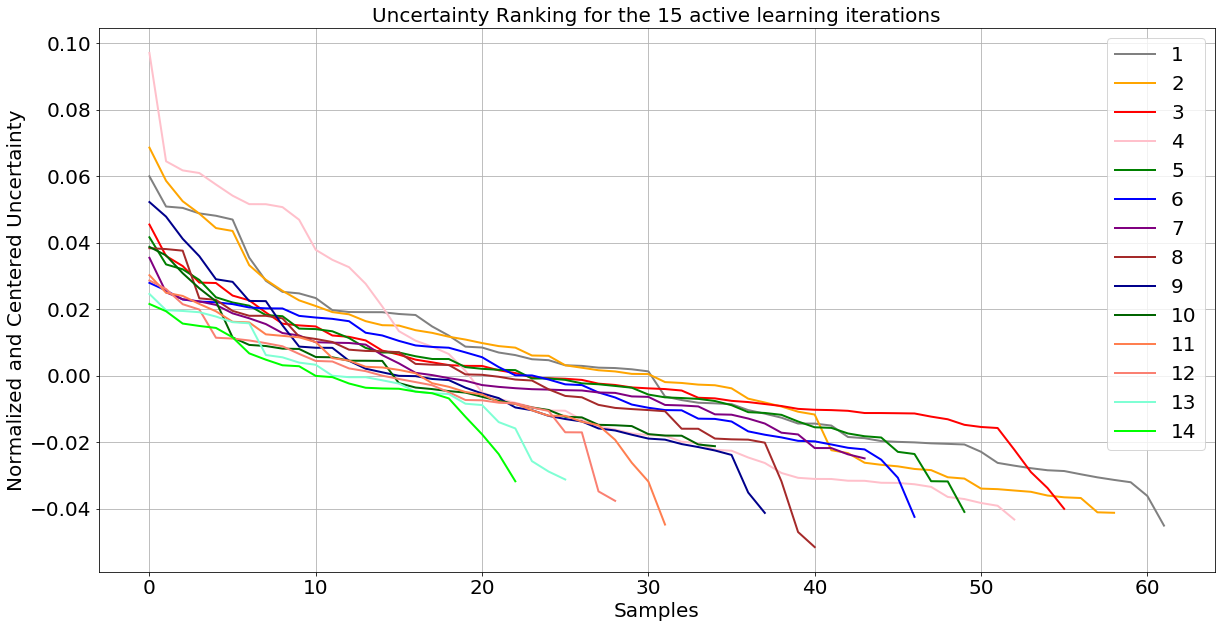

In [76]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    return v / norm

def plot_uncertainty(nb_active_learning_iter, uncertain_iter):
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.title("Uncertainty Ranking for the 15 active learning iterations", fontsize = 20)
    plt.xlabel("Samples", fontsize = 20)
    plt.ylabel('Normalized and Centered Uncertainty', fontsize = 20)
    color = ['black','grey', 'orange', 'red', 'pink', 'green', 'blue', 'purple', 'brown', 'darkblue', 'darkgreen', 'coral', 
            'salmon', 'aquamarine', 'lime' , 'teal', 'violet', 'orchid' ]
    
    for i in range(1, nb_active_learning_iter):
        A = normalize(uncertain_iter[i][uncertain_iter[i] > 0])
        plt.plot(np.flip(np.sort(A - A.mean(axis=0)), 0), color=color[i], linewidth=2.0)
        plt.legend(range(1, nb_active_learning_iter), fontsize = 20)
        #plt.xlim(0,30)
        
    plt.show()
    
plot_uncertainty(nb_active_learning_iter, uncertain_iter)

In [209]:
timestamp

'1009_1143_33'

# Analysis 

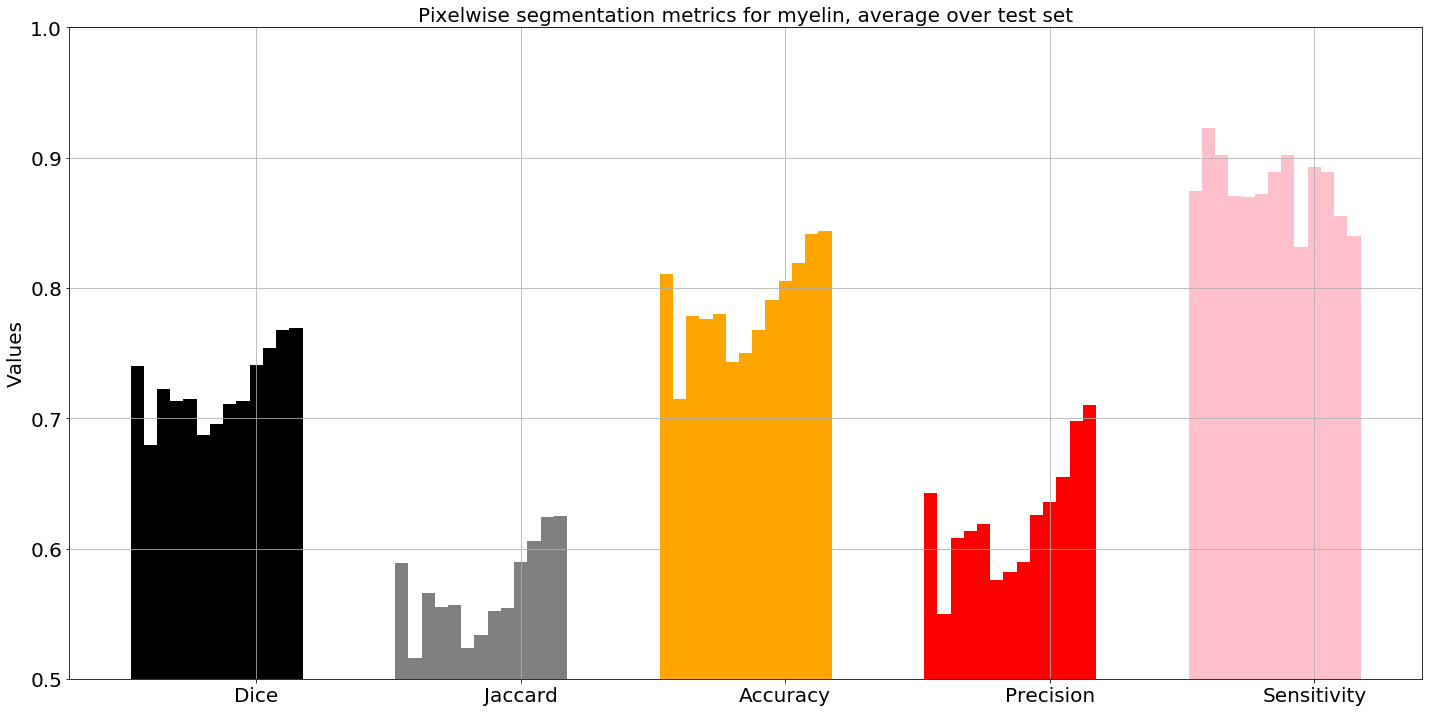

In [26]:
n_groups = 5
width=0.05
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(1, 14, 1):
    plot = np.arange(-0.5, 3.8, width)
    color = "C" + str(i)
    color = np.arange(0.05, 1, 0.05)
    color = ['black','grey', 'orange', 'red', 'pink', 'green', 'blue', 'purple', 'brown', 'darkblue', 'darkgreen', 'coral', 
            'ivory', 'lavender', 'lime', 'salmon', 'teal', 'violet', 'orchid', 'azure', 'aquamarine']
    rects1 = plt.bar(index + plot[i], score_global[i], width=width, color=color,label=i)
    

plt.ylabel('Values',fontsize=20)
plt.title('Pixelwise segmentation metrics for myelin, average over test set',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(loc='best',fontsize=20)
plt.grid(True)
plt.ylim(0.5, 1)

plt.tight_layout()
plt.show()

In [42]:
score_relative = score_global
score_relative

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.74016984, 0.58856425, 0.81072402, 0.64274444, 0.87416432],
       [0.67945826, 0.5158072 , 0.71494889, 0.54963415, 0.92259488],
       [0.72244268, 0.56613144, 0.77812934, 0.60821108, 0.90236872],
       [0.71316822, 0.55483266, 0.77597952, 0.61377437, 0.87051585],
       [0.71504593, 0.55697674, 0.7796669 , 0.61871782, 0.86964313],
       [0.68683101, 0.52399269, 0.74292278, 0.57588617, 0.87207709],
       [0.69541777, 0.53370812, 0.74979138, 0.5818506 , 0.88911729],
       [0.71115486, 0.55235145, 0.76806021, 0.58959386, 0.90242642],
       [0.71324457, 0.55469989, 0.79048204, 0.62597456, 0.83145143],
       [0.74114866, 0.58938698, 0.8056159 , 0.63542024, 0.89284255],
       [0.75372417, 0.60540306, 0.81914449, 0.6550704 , 0.88916395],
       [0.76780442, 0.62435445, 0.84169888, 0.69803107, 0.85560307],
       [0.76891547, 0.62519733, 0.84403324, 0.70986026, 0.83978501],
       [0.77448318, 0.63312206, 0.

In [43]:
score_relative = np.delete(score_relative, 0, 0)

In [46]:
score_relative.shape

(15, 5)

In [58]:
diff = np.zeros((14, 5))
print(diff)
for j in range(0, 5):
    for i in range(0, 14):
        #print(i, j)
        diff[i, j] = score_relative[i+1, j] - score_relative[i, j] 
        #print(diff)
        
diff.shape

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


(14, 5)

In [59]:
diff

array([[-0.06071158, -0.07275705, -0.09577513, -0.09311029,  0.04843056],
       [ 0.04298443,  0.05032425,  0.06318045,  0.05857694, -0.02022616],
       [-0.00927446, -0.01129878, -0.00214982,  0.00556329, -0.03185287],
       [ 0.00187771,  0.00214407,  0.00368738,  0.00494345, -0.00087272],
       [-0.02821492, -0.03298405, -0.03674412, -0.04283165,  0.00243396],
       [ 0.00858676,  0.00971543,  0.0068686 ,  0.00596443,  0.0170402 ],
       [ 0.01573709,  0.01864334,  0.01826882,  0.00774326,  0.01330914],
       [ 0.00208971,  0.00234844,  0.02242184,  0.0363807 , -0.070975  ],
       [ 0.02790409,  0.03468709,  0.01513386,  0.00944568,  0.06139112],
       [ 0.0125755 ,  0.01601608,  0.01352859,  0.01965016, -0.00367859],
       [ 0.01408026,  0.01895138,  0.0225544 ,  0.04296067, -0.03356088],
       [ 0.00111105,  0.00084289,  0.00233436,  0.01182919, -0.01581806],
       [ 0.00556771,  0.00792473,  0.00239539, -0.00220943,  0.01788289],
       [-0.00240231, -0.00107624,  0.0

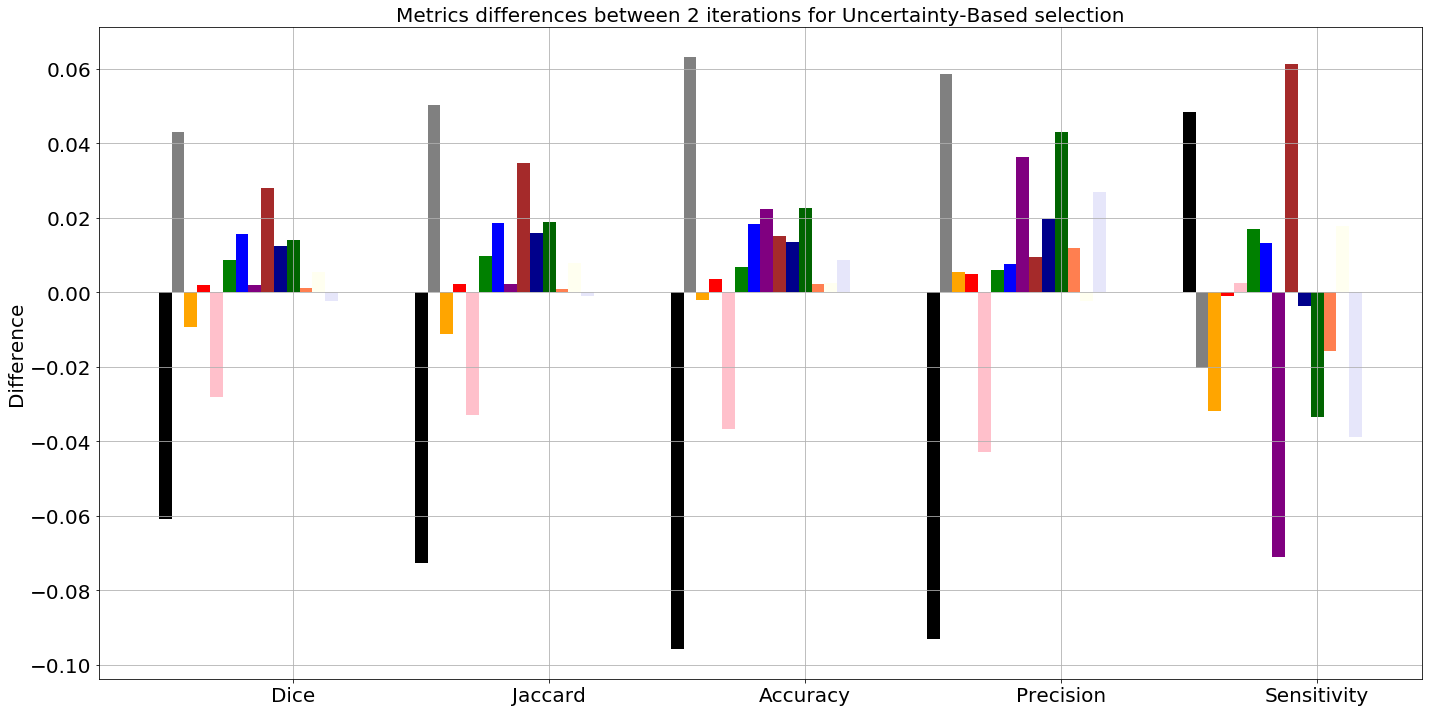

In [60]:
n_groups = 5
width=0.05
fig, ax = plt.subplots(figsize = (20, 10))
index = np.arange(n_groups)

for i in np.arange(0, 14):

    plot = np.arange(-0.5, 3.8, width)
    color = "C" + str(i)
    color = ['black','grey', 'orange', 'red', 'pink', 'green', 'blue', 'purple', 'brown', 'darkblue', 'darkgreen', 'coral', 
            'ivory', 'lavender', 'lime', 'salmon', 'teal', 'violet', 'orchid', 'azure', 'aquamarine']

    rects1 = plt.bar(index + plot[i], diff[i, :], width=width, color=color[i], label=i)
    
plt.ylabel('Difference',fontsize=20)
plt.title('Metrics differences between 2 iterations for Uncertainty-Based selection',fontsize=20)
plt.xticks(index, ('Dice', 'Jaccard', 'Accuracy', 'Precision', 'Sensitivity'),fontsize=20)
plt.yticks(fontsize=20)
#plt.legend(loc='best',fontsize=20)
plt.grid(True)
#plt.ylim(-0.04, 0.1)

plt.tight_layout()
plt.show()

In [81]:
def read_history(history_path):
    txt_file = open(history_path,'r')
    text = txt_file.read()[2:-1].split(", '")

    loss = np.fromstring(text[0].split("[")[1][:-1], sep=',')
    val_dice_coef = np.fromstring(text[1].split("[")[1][:-1], sep=',')
    val_loss = np.fromstring(text[2].split("[")[1][:-1], sep=',')
    dice_coef = np.fromstring(text[3].split("[")[1][:-1], sep=',')
    return loss, val_dice_coef, val_loss, dice_coef


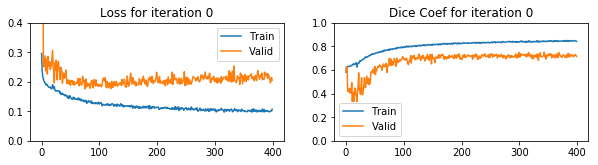

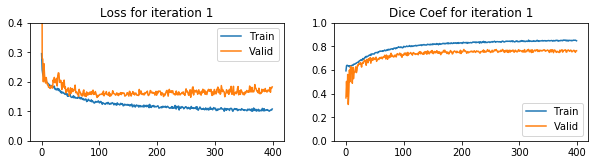

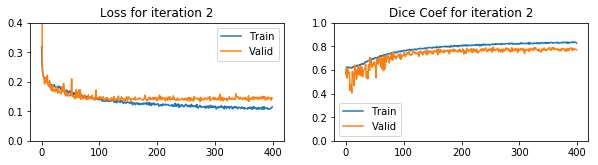

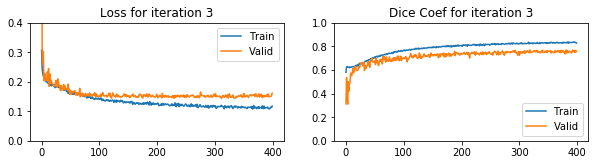

In [83]:
for i  in range(4):
    history_path = ['/home/malub_local/history/1004_0723_52_history_iter_0_.txt', 
                    "/home/malub_local/history/1004_0723_52_history_iter_1_.txt", 
                    "/home/malub_local/history/1004_0723_52_history_iter_2_.txt",
                   "/home/malub_local/history/1004_0723_52_history_iter_3_.txt"] 
    loss, val_dice_coef, val_loss, dice_coef = read_history(history_path[i])
    fig, ax = plt.subplots(figsize = (10, 10))
    plt.subplot(420 + 2*i + 1)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title("Loss for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 0.4)
    plt.subplot(420 + 2*i + 2)
    plt.plot(dice_coef)
    plt.plot(val_dice_coef)
    plt.title("Dice Coef for iteration " + str(i))
    plt.legend(["Train", "Valid"])
    plt.ylim(0, 1)
    plt.show()

## Display segmentation for X_test 

In [256]:
threshold = 0.4
uncertain_test, uncertain_map_test, predictions_test = uncertainty_for_ranking(model, X_test)

Computing predictions for unlabelled data ...



In [257]:
predictions_test = np.asarray(predictions_test)
predictions_test.shape



(16, 512, 512)

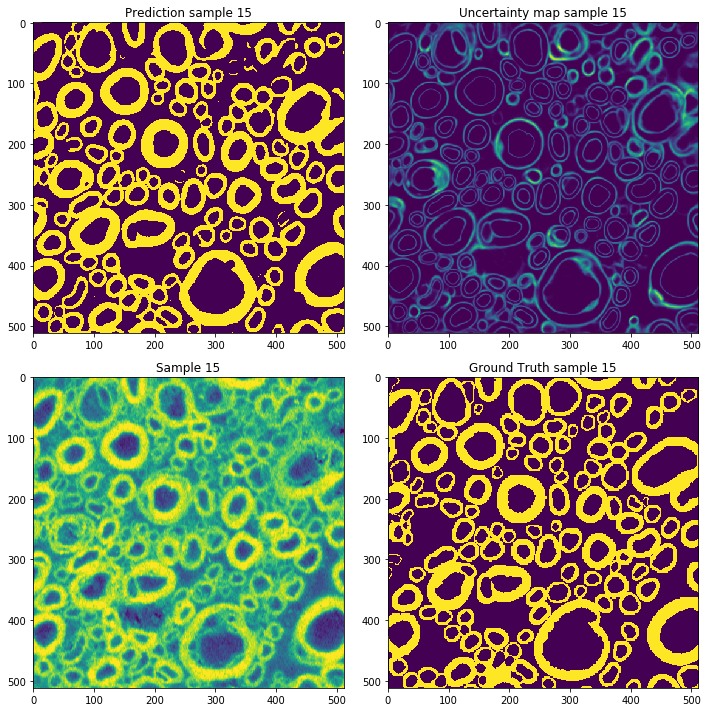

In [264]:
# Plot predictions and uncertainty map for 2 samples 
rand_int = random.randint(0, len(X_test)-1)
rand_int = 15
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(predictions_test[rand_int][:,:])
plt.title("Prediction sample " + str(rand_int))
plt.subplot(222)
plt.imshow(uncertain_map_test[rand_int])
plt.title("Uncertainty map sample "+ str(rand_int))
plt.subplot(223)
plt.imshow(X_test[rand_int][0,:,:])
plt.title("Sample "+ str(rand_int))
plt.subplot(224)
plt.imshow(y_test[rand_int][0,:,:])
plt.title("Ground Truth sample "+ str(rand_int))
plt.tight_layout()
plt.show()


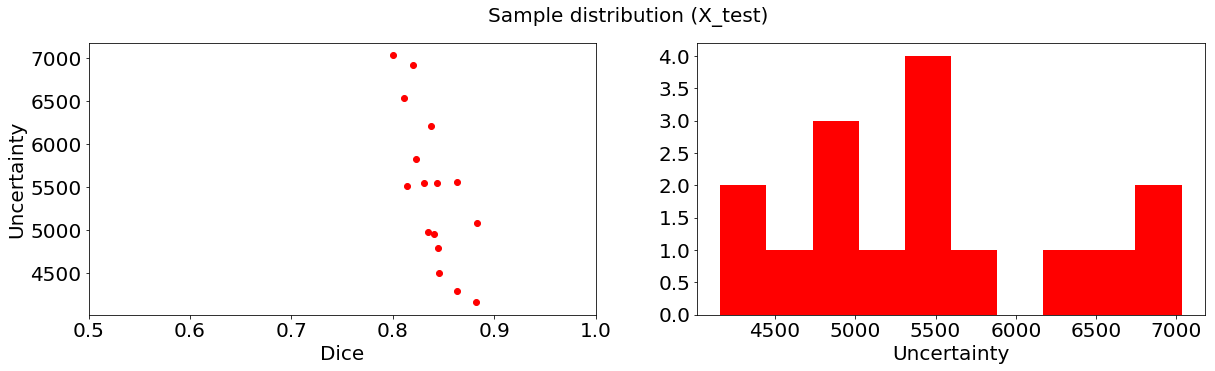

In [133]:
dice_plot = np.zeros(len(X_test))


for i in range(len(X_test)):
    dice_plot[i] = compute_dice_coef(y_test[i][0,:,:], predictions_test[i][:,:])
    

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.scatter(dice_plot, uncertain_test, color = "red")
plt.xlabel("Dice", fontsize=20)
plt.ylabel("Uncertainty", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0.5, 1)

plt.subplot(122)
plt.hist(uncertain_test.flatten(), 10, color = "red")
plt.xlabel("Uncertainty", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.suptitle("Sample distribution (X_test)", fontsize=20)
plt.show()

In [54]:
acc

array([0.87511444, 0.86398315, 0.88320541, 0.91376877, 0.88190079,
       0.85490799, 0.84724045, 0.91880035, 0.8605423 , 0.95693207,
       0.88864899, 0.89064789, 0.90397644, 0.84415817, 0.88794708,
       0.87411118])

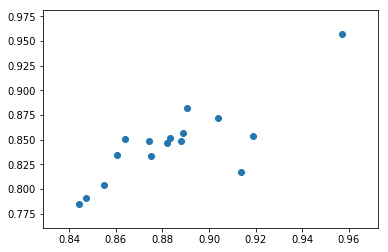

In [55]:
plt.scatter(acc, dice)

## Choose threshold 

In [84]:
# uncertainty computation
dice_coef_test = np.zeros(len(X_test))
dice = []

print("Computing log predictions ...\n")
predictions = predict(X_test, model)

for threshold in np.arange(0, 1, 0.05):
    dice_coef_test = np.zeros(len(X_test))
    for i in range(len(X_test)):
        sample = X_test[i].reshape([1, 1, img_rows, img_cols])
        sample_prediction = cv2.threshold(predictions[i], threshold, 1, cv2.THRESH_BINARY)[1].astype('uint8')
        dice_coef_test[i] = compute_dice_coef(y_test[i][0], sample_prediction)
    dice.append(np.mean(dice_coef_test))


print(len(dice))
print("Done")


Computing log predictions ...

20
Done


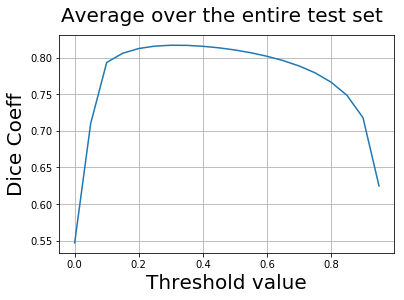

In [85]:
plt.plot(np.arange(0, 1, 0.05), dice )
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.ylabel("Dice Coeff", fontsize = 20)
plt.xlabel("Threshold value", fontsize = 20)
plt.grid()
#plt.ylim(0.7, 0.75)
plt.show()

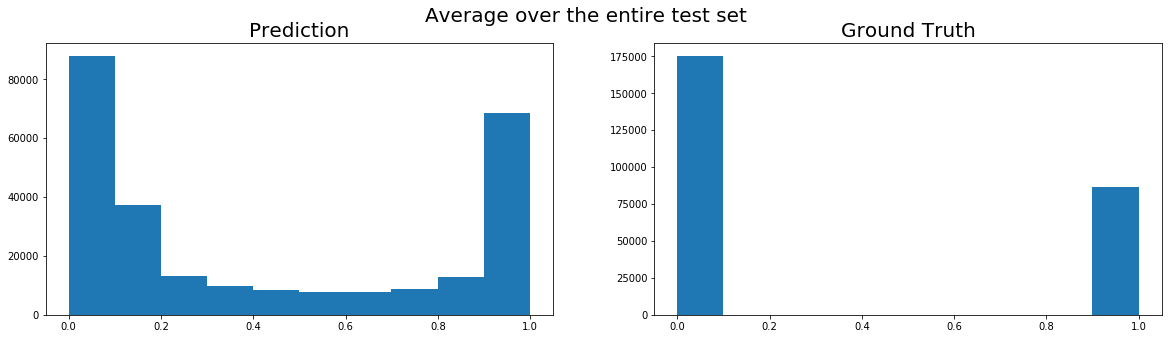

In [33]:
plt.figure(figsize=(20,5))
plt.suptitle("Average over the entire test set", fontsize = 20)
plt.subplot(121)
plt.hist(predictions[0].flatten())
plt.title("Prediction", fontsize = 20)
plt.subplot(122)
plt.hist(y_test[0].flatten())
plt.title("Ground Truth", fontsize = 20)
plt.show()

# Visuaize Data Augmentation

In [ ]:
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def visualize_data_augmentation(generator):
    batch1 = take(1, generator)
    max_images = 16
    grid_width = 8
    grid_height = 1
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(img, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])


    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 10))
    for i in range(8):
        img = batch1[0][0][i, 0, :, :]
        mask = batch1[0][1][i, 0, :, :]
        ax = axs[ i % grid_width]
        ax.imshow(mask, cmap="gray")
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [ ]:
visualize_data_augmentation(train_generator)